Installing (updating) the following libraries for your Sagemaker
instance.

In [ ]:
!pip install .. # installing d2l


# Modelos de Linguagem e o *Dataset*
:label:`sec_language_model`


Em :numref:`sec_text_preprocessing`,  vemos como mapear dados de texto em tokens, onde esses tokens podem ser vistos como uma sequência de observações discretas, como palavras ou caracteres.
Suponha que os tokens em uma sequência de texto de comprimento $T$ sejam, por sua vez, $x_1, x_2, \ldots, x_T$. 
Então, na sequência de texto,
$x_t$($1 \leq t \leq T$) pode ser considerado como a observação ou rótulo no intervalo de tempo $t$. Dada essa sequência de texto,
o objetivo de um *modelo de linguagem* é estimar a probabilidade conjunta da sequência

$$P(x_1, x_2, \ldots, x_T).$$


Os modelos de linguagem são incrivelmente úteis. Por exemplo, um modelo de linguagem ideal seria capaz de gerar texto natural sozinho, simplesmente desenhando um token por vez $x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1)$.
Bem ao contrário do macaco usando uma máquina de escrever, todo texto emergente de tal modelo passaria como linguagem natural, por exemplo, texto em inglês. Além disso, seria suficiente para gerar um diálogo significativo, simplesmente condicionando o texto a fragmentos de diálogo anteriores.
Claramente, ainda estamos muito longe de projetar tal sistema, uma vez que seria necessário *compreender* o texto em vez de apenas gerar conteúdo gramaticalmente sensato.

No entanto, os modelos de linguagem são de grande utilidade, mesmo em sua forma limitada.
Por exemplo, as frases "reconhecer a fala" e "destruir uma bela praia" [^1] soam muito semelhantes.
Isso pode causar ambiguidade no reconhecimento de fala,
o que é facilmente resolvido por meio de um modelo de linguagem que rejeita a segunda tradução como bizarra.
Da mesma forma, em um algoritmo de sumarização de documentos
vale a pena saber que "cachorro morde homem" é muito mais frequente do que "homem morde cachorro", ou que "quero comer vovó" é uma afirmação um tanto perturbadora, enquanto "quero comer, vovó" é muito mais benigna.

[^1]: Traduzido de  *to recognize speech* e *to wreck a nice beach*


## Aprendendo um Modelo de Linguagem

A questão óbvia é como devemos modelar um documento, ou mesmo uma sequência de tokens.
Suponha que tokenizemos dados de texto no nível da palavra.
Podemos recorrer à análise que aplicamos aos modelos de sequência em :numref:`sec_sequence`.
Vamos começar aplicando regras básicas de probabilidade:

$$P(x_1, x_2, \ldots, x_T) = \prod_{t=1}^T P(x_t  \mid  x_1, \ldots, x_{t-1}).$$

Por exemplo,
a probabilidade de uma sequência de texto contendo quatro palavras seria dada como:

$$P(\text{deep}, \text{learning}, \text{é}, \text{divertido}) =  P(\text{deep}) P(\text{learning}  \mid  \text{deep}) P(\text{é}  \mid  \text{deep}, \text{learning}) P(\text{divertido}  \mid  \text{deep}, \text{learning}, \text{é}).$$


Para calcular o modelo de linguagem, precisamos calcular a
probabilidade de palavras e a probabilidade condicional de uma palavra dada
as poucas palavras anteriores.
Essas probabilidades são essencialmente
parâmetros do modelo de linguagem.

Aqui nós
supomos que o conjunto de dados de treinamento é um grande corpus de texto, como todas as
entradas da Wikipedia, [Project Gutenberg](https://en.wikipedia.org/wiki/Project_Gutenberg),
e todo o texto postado no
wede.
A probabilidade das palavras pode ser calculada a partir da palavra relativa
frequência de uma determinada palavra no conjunto de dados de treinamento.
Por exemplo, a estimativa $\hat{P}(\text{deep})$ pode ser calculada como o
probabilidade de qualquer frase que comece com a palavra "deep". Uma
abordagem ligeiramente menos precisa seria contar todas as ocorrências de
a palavra "deep" e dividi-la pelo número total de palavras em
o corpus.
Isso funciona muito bem, especialmente para
palavras. Continuando, podemos tentar estimar

$$\hat{P}(\text{learning} \mid \text{deep}) = \frac{n(\text{deep, learning})}{n(\text{deep})},$$


onde $n(x)$ e $n(x, x')$ são o número de ocorrências de *singletons*
e pares de palavras consecutivas, respectivamente.
Infelizmente, estimando a
probabilidade de um par de palavras é um pouco mais difícil, uma vez que
as ocorrências de "deep learning" são muito menos frequentes. No
em particular, para algumas combinações incomuns de palavras, pode ser complicado
encontrar ocorrências suficientes para obter estimativas precisas.
As coisas pioram com as combinações de três palavras e além.
Haverá muitas combinações plausíveis de três palavras que provavelmente não veremos em nosso conjunto de dados.
A menos que forneçamos alguma solução para atribuir tais combinações de palavras contagens diferentes de zero, não poderemos usá-las em um modelo de linguagem. Se o conjunto de dados for pequeno ou se as palavras forem muito raras, podemos não encontrar nem mesmo uma delas.

Uma estratégia comum é realizar alguma forma de *suavização de Laplace*.
A solução é
adicionar uma pequena constante a todas as contagens.
Denote por $n$ o número total de palavras em
o conjunto de treinamento
e $m$ o número de palavras únicas.
Esta solução ajuda com singletons, por exemplo, via

$$\begin{aligned}
	\hat{P}(x) & = \frac{n(x) + \epsilon_1/m}{n + \epsilon_1}, \\
	\hat{P}(x' \mid x) & = \frac{n(x, x') + \epsilon_2 \hat{P}(x')}{n(x) + \epsilon_2}, \\
	\hat{P}(x'' \mid x,x') & = \frac{n(x, x',x'') + \epsilon_3 \hat{P}(x'')}{n(x, x') + \epsilon_3}.
\end{aligned}$$


Aqui $\epsilon_1,\epsilon_2$, and $\epsilon_3$ são hiperparâmetros.
Tome $\epsilon_1$ como exemplo:
quando $\epsilon_1 = 0$, nenhuma suavização é aplicada;
quando $\epsilon_1$ se aproxima do infinito positivo,
$\hat{P}(x)$ se aproxima da probabilidade uniforme $1/m$. 
O acima é uma variante bastante primitiva do que
outras técnicas podem realizar: cite: `Wood.Gasthaus.Archambeau.ea.2011`.


Infelizmente, modelos como este tornam-se difíceis de manejar rapidamente
pelos seguintes motivos. Primeiro, precisamos armazenar todas as contagens.
Em segundo lugar, isso ignora inteiramente o significado das palavras. Para
Por exemplo, "gato" e "felino" devem ocorrer em contextos relacionados.
É muito difícil ajustar esses modelos a contextos adicionais,
Considerando que, modelos de linguagem baseados em aprendizagem profunda são bem adequados para
levar em consideração.
Por último, sequências de palavras longas
são quase certas de serem novas, portanto, um modelo que simplesmente
conta que a frequência de sequências de palavras vistas anteriormente tem um desempenho insatisfatório.

## Modelos de Markov e $n$-gramas

Antes de discutirmos as soluções que envolvem o *deep learning*, precisamos de mais terminologia e conceitos. Lembre-se de nossa discussão sobre os Modelos de Markov em :numref:`sec_sequence`.
Vamos aplicar isso à modelagem de linguagem. Uma distribuição sobre sequências satisfaz a propriedade Markov de primeira ordem se $P(x_{t+1} \mid x_t, \ldots, x_1) = P(x_{t+1} \mid x_t)$. Ordens mais altas correspondem a dependências mais longas. Isso leva a uma série de aproximações que podemos aplicar para modelar uma sequência:

$$
\begin{aligned}
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2) P(x_3) P(x_4),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_2) P(x_4  \mid  x_3),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_1, x_2) P(x_4  \mid  x_2, x_3).
\end{aligned}
$$

As fórmulas de probabilidade que envolvem uma, duas e três variáveis são normalmente referidas como modelos *unigrama*, *bigrama* e *trigrama*, respectivamente. A seguir, aprenderemos como projetar modelos melhores.

## Estatísticas de Linguagem Natural

Vamos ver como isso funciona com dados reais.
Construímos um vocabulário baseado no conjunto de dados da máquina do tempo, conforme apresentado em :numref:`sec_text_preprocessing` 
e imprima as 10 palavras mais frequentes.


In [1]:
import random
import torch
from d2l import torch as d2l

In [2]:
tokens = d2l.tokenize(d2l.read_time_machine())
# Since each text line is not necessarily a sentence or a paragraph, we
# concatenate all text lines
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

Como podemos ver, as palavras mais populares são realmente muito chatas de se olhar.
Freqüentemente, são chamadas de *palavras de interrupção* e, portanto, são filtradas.
No entanto, eles ainda carregam significado e ainda os usaremos.
Além disso, é bastante claro que a palavra frequência decai rapidamente. A $10^{\mathrm{a}}$ palavra mais frequente é menos de $1/5$ tão comum quanto a mais popular. Para se ter uma ideia melhor, traçamos a figura da frequência da palavra.


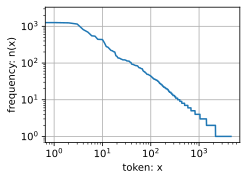

In [3]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

Chegamos a algo bastante fundamental aqui: a frequência da palavra  decai rapidamente de uma forma bem definida.
Depois de lidar com as primeiras palavras como exceções, todas as palavras restantes seguem aproximadamente uma linha reta em um gráfico log-log. Isso significa que as palavras satisfazem a *lei de Zipf*,
que afirma que a frequência $n_i$ da $i^\mathrm{a}$ palavra mais frequente
é:

$$n_i \propto \frac{1}{i^\alpha},$$
:eqlabel:`eq_zipf_law`

que é equivalente a

$$\log n_i = -\alpha \log i + c,$$

onde $\alpha$ é o expoente que caracteriza a distribuição e $c$ é uma constante.
Isso já deve nos dar uma pausa se quisermos modelar palavras por estatísticas de contagem e suavização.
Afinal, superestimaremos significativamente a frequência da cauda, também conhecida como palavras infrequentes. Mas e quanto às outras combinações de palavras, como bigramas, trigramas e além?
Vamos ver se a frequência do bigrama se comporta da mesma maneira que a frequência do unigrama.


In [4]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

Uma coisa é notável aqui. Dos dez pares de palavras mais frequentes, nove são compostos de palavras irrelevantes e apenas um é relevante para o livro real --- "o tempo". Além disso, vejamos se a frequência do trigrama se comporta da mesma maneira.


In [5]:
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

Por último, vamos visualizar a frequência do token entre esses três modelos: unigramas, bigramas e trigramas.


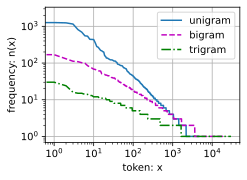

In [6]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

Esse número é bastante empolgante por uma série de razões. Primeiro, além das palavras unigrama, as sequências de palavras também parecem seguir a lei de Zipf, embora com um expoente menor $\alpha$ em :eqref:`eq_zipf_law`,  dependendo do comprimento da sequência.
Em segundo lugar, o número de $n$-gramas distintos não é tão grande. Isso nos dá esperança de que haja uma grande estrutura na linguagem.
Terceiro, muitos $n$-gramas ocorrem muito raramente, o que torna a suavização de Laplace bastante inadequada para modelagem de linguagem. Em vez disso, usaremos modelos baseados em *deep learning*.


## Leitura de Dados de Longa Sequência


Uma vez que os dados da sequência são, por sua própria natureza, sequenciais, precisamos abordar
a questão de processá-la.
Fizemos isso de uma maneira bastante ad-hoc em :numref:`sec_sequence`.
Quando as sequências ficam muito longas para serem processadas por modelos
tudas de uma vez,
podemos desejar dividir essas sequências para leitura.
Agora vamos descrever as estratégias gerais.
Antes de apresentar o modelo,
vamos supor que usaremos uma rede neural para treinar um modelo de linguagem,
onde a rede processa um minibatch de sequências com comprimento predefinido, digamos $n$ etapas de tempo, de cada vez.
Agora, a questão é como ler minibatches de recursos e rótulos aleatoriamente.

Começando,
uma vez que uma sequência de texto pode ser arbitrariamente longa,
como todo o livro *The Time Machine*,
podemos particionar uma sequência tão longa em subsequências
com o mesmo número de etapas de tempo.
Ao treinar nossa rede neural,
um minibatch de tais subsequências
será alimentado no modelo.
Suponha que a rede processe uma subsequência
de $n$ passos de tempo
de uma vez.
:numref:`fig_timemachine_5gram`
mostra todas as diferentes maneiras de obter subsequências
de uma sequência de texto original, onde $n=5$ e um token em cada etapa corresponde a um caractere.
Observe que temos bastante liberdade, pois podemos escolher um deslocamento arbitrário que indica a posição inicial.

![Different offsets lead to different subsequences when splitting up text.](../img/timemachine-5gram.svg)
:label:`fig_timemachine_5gram`

Portanto, qual devemos escolher de :numref:`fig_timemachine_5gram`?
Na verdade, todos eles são igualmente bons.
No entanto, se escolhermos apenas um deslocamento,
há cobertura limitada de todas as possíveis subsequências
para treinar nossa rede.
Portanto,
podemos começar com um deslocamento aleatório para particionar uma sequência
para obter *cobertura* e *aleatoriedade*.
Na sequência,
descrevemos como fazer isso para ambos
*estratégias de amostragem aleatória* e *particionamento sequencial*.


### Amostragem Aleatória


Na amostragem aleatória, cada exemplo é uma subsequência capturada arbitrariamente na longa sequência original.
As subsequências de dois minibatches aleatórios adjacentes
durante a iteração
não são necessariamente adjacentes na sequência original.
Para modelagem de linguagem,
o objetivo é prever o próximo token com base nos tokens que vimos até agora, portanto, os rótulos são a sequência original, deslocada por um token.

O código a seguir gera aleatoriamente um minibatch dos dados a cada vez.
Aqui, o argumento `batch_size` especifica o número de exemplos de subsequência em cada minibatch
e `num_steps` é o número predefinido de etapas de tempo
em cada subsequência.


In [7]:
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """Generate a minibatch of subsequences using random sampling."""
    # Start with a random offset (inclusive of `num_steps - 1`) to partition a
    # sequence
    corpus = corpus[random.randint(0, num_steps - 1):]
    # Subtract 1 since we need to account for labels
    num_subseqs = (len(corpus) - 1) // num_steps
    # The starting indices for subsequences of length `num_steps`
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # In random sampling, the subsequences from two adjacent random
    # minibatches during iteration are not necessarily adjacent on the
    # original sequence
    random.shuffle(initial_indices)

    def data(pos):
        # Return a sequence of length `num_steps` starting from `pos`
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # Here, `initial_indices` contains randomized starting indices for
        # subsequences
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

Vamos gerar manualmente uma sequência de 0 a 34.
Nós assumimos que
o tamanho do lote e o número de etapas de tempo são 2 e 5,
respectivamente.
Isso significa que podemos gerar $\lfloor (35 - 1) / 5 \rfloor= 6$  pares de subsequências de rótulo de recurso. Com um tamanho de minibatch de 2, obtemos apenas 3 minibatches.


In [8]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[23, 24, 25, 26, 27],
        [28, 29, 30, 31, 32]]) 
Y: tensor([[24, 25, 26, 27, 28],
        [29, 30, 31, 32, 33]])
X:  tensor([[18, 19, 20, 21, 22],
        [13, 14, 15, 16, 17]]) 
Y: tensor([[19, 20, 21, 22, 23],
        [14, 15, 16, 17, 18]])
X:  tensor([[ 3,  4,  5,  6,  7],
        [ 8,  9, 10, 11, 12]]) 
Y: tensor([[ 4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13]])


### Particionamento Sequencial

Além da amostragem aleatória da sequência original, também podemos garantir que
as subsequências de dois minibatches adjacentes
durante a iteração
são adjacentes na sequência original.
Essa estratégia preserva a ordem das subsequências divididas ao iterar em minibatches; portanto, é chamada de particionamento sequencial.


In [9]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """Generate a minibatch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

Usando as mesmas configurações,
vamos imprimir as *features* `X` e os rótulos `Y` para cada minibatch de subsequências lidas por particionamento sequencial.
Observe que
as subsequências de dois minibatches adjacentes
durante a iteração
são de fato adjacentes na sequência original.


In [10]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 5,  6,  7,  8,  9],
        [19, 20, 21, 22, 23]]) 
Y: tensor([[ 6,  7,  8,  9, 10],
        [20, 21, 22, 23, 24]])
X:  tensor([[10, 11, 12, 13, 14],
        [24, 25, 26, 27, 28]]) 
Y: tensor([[11, 12, 13, 14, 15],
        [25, 26, 27, 28, 29]])


Agora, agrupamos as duas funções de amostragem acima em uma classe para que possamos usá-la como um iterador de dados posteriormente.


In [11]:
class SeqDataLoader:  #@save
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

Por último, definimos uma função `load_data_time_machine` que retorna o iterador de dados e o vocabulário, para que possamos usá-lo da mesma forma que outras funções com o prefixo `load_data`, como `d2l.load_data_fashion_mnist` definido em :numref:`sec_fashion_mnist`.


In [12]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

## Resumo

* Modelos de linguagem são fundamentais para o processamento de linguagem natural.
* $n$-grams fornecem um modelo conveniente para lidar com sequências longas truncando a dependência.
* Sequências longas sofrem com o problema de ocorrerem muito raramente ou nunca.
* A lei de Zipf rege a distribuição de palavras não apenas para unigramas, mas também para os outros $n$-gramas.
* Há muita estrutura, mas não frequência suficiente para lidar com combinações de palavras infrequentes de forma eficiente por meio da suavização de Laplace.
* As principais opções para ler sequências longas são a amostragem aleatória e o particionamento sequencial. O último pode garantir que as subsequências de dois minibatches adjacentes durante a iteração sejam adjacentes à sequência original.

## Exercícios

1. Suponha que haja $100.000$ palavras no conjunto de dados de treinamento. Quanta frequência de palavra e frequência adjacente de várias palavras um quadrigrama precisa armazenar?
1. Como você modelaria um diálogo?
1. Estime o expoente da lei de Zipf para unigramas, bigramas e trigramas.
1. Em que outros métodos você pode pensar para ler dados de sequência longa?
1. Considere o deslocamento aleatório que usamos para ler sequências longas.
     1. Por que é uma boa ideia ter um deslocamento aleatório?
     1. Isso realmente leva a uma distribuição perfeitamente uniforme nas sequências do documento?
     1. O que você teria que fazer para tornar as coisas ainda mais uniformes?
1. Se quisermos que um exemplo de sequência seja uma frase completa, que tipo de problema isso apresenta na amostragem de minibatch? Como podemos resolver o problema?


[Discussions](https://discuss.d2l.ai/t/118)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTEzNzc0OTg3MjQsMTgwODk0ODc4MiwtMT
k1MzUxMjczOSwtNjI3NTQzOTI3LC01MjEwMTgwOTYsLTQzNjM1
MzM0NSwtNjI5NDU2ODQyXX0=
-->
